# Kickstarter Projects 
### CSC 478 Final Project
#### Synopsis:
* The purpose of this project is to predict whether a kickstarter campaign will fail, succeed, or cancel based on the available information available [here](https://raw.githubusercontent.com/stfox13/CSC478FinalProject/master/Data/ks-projects-201801.csv).
* We will use an array of machine learning algorithms, including KNN, Linear Regression, Logistic Regression, and / or SVM to find the most accurate model.

#### Contributors:
* [Rebecca Tung (1448196)](https://github.com/rtungus)
* [Sidney Fox (1524992)](https://github.com/stfox13)

#### Data Dictionary:


##### Content
You'll find most useful data for project analysis. Columns are self explanatory except:

1. usd_pledged: conversion in US dollars of the pledged column (conversion done by kickstarter).

2. usd pledge real: conversion in US dollars of the pledged column (conversion from Fixer.io API).

3. usd goal real: conversion in US dollars of the goal column (conversion from Fixer.io API).


|Sequence Number|Column Name|Data Type|
|:---|:---|:---|
|1|ID|Numeric|
|2|name|String|
|3|category|String|
|4|main_category|String|
|5|currency|String|
|6|deadline|DateTime|
|7|goal|Numeric|
|8|launched|DateTime|
|9|pledged|Numeric|
|10|state|String|
|11|backers|Numeric|
|12|country|String|
|13|usd pledged|Numeric|
|14|usd_pledged_real|Numeric|
|15|usd_goal_real|Numeric|

## Libraries used through the project:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#import plotly.plotly as py
import numpy as np
import pandas as pd
import seaborn as sns
import os
import math
import requests
import datetime as dt
import matplotlib as mpl
import io
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
#Set graph size
mpl.rcParams['figure.figsize'] = (5,5)

In [4]:
np.set_printoptions(suppress=True)

## Load raw data as Pandas DataFrame:

In [5]:
url = 'https://raw.githubusercontent.com/stfox13/CSC478FinalProject/master/Data/ks-projects-201801.csv'
kickproj_org= pd.read_csv(url)
len(kickproj_org)

378661

## Check the Y data:

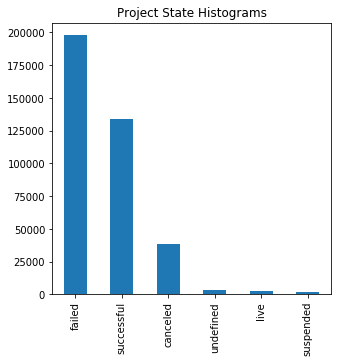

In [6]:
#Plot histogram
kickproj_org['state'].value_counts().plot(kind='bar', title='Project State Histograms')

### Drop projects when the state is equal to "undefined":

375099

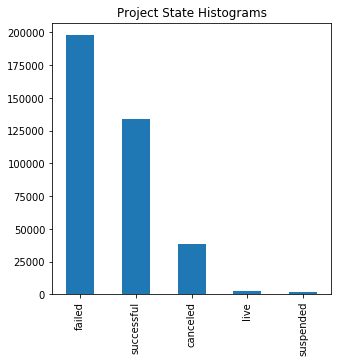

In [20]:
# Remove state = 'undefined'
kickproj = kickproj_org[kickproj_org['state'] != 'undefined']
len(kickproj)
kickproj['state'].value_counts().plot(kind='bar', title='Project State Histograms')

In [21]:
kickproj.head(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


#### Since we have the goal and pledge amounts converted to US dollars (usd), we will drop the original goal and pledged columns:

In [22]:
#kickproj = kickproj[kickproj.columns.difference(['goal','pledged','usd pledged'])]
kickproj = kickproj.drop(['goal','pledged','usd pledged'], axis=1)
len(kickproj)
kickproj.head(5)

375099

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,canceled,14,US,1283.0,19500.00


## Check the X data:

In [23]:
kickproj.describe()

,ID,backers,usd_pledged_real,usd_goal_real
count,3.750990e+05,375099.000000,3.750990e+05,3.750990e+05
mean,1.074632e+09,106.620436,9.123935e+03,4.584708e+04
std,6.191294e+08,911.423593,9.140142e+04,1.158404e+06
min,5.971000e+03,0.000000,0.000000e+00,1.000000e-02
25%,5.380782e+08,2.000000,3.100000e+01,2.000000e+03
50%,1.075217e+09,12.000000,6.250000e+02,5.500000e+03
75%,1.610128e+09,57.000000,4.050180e+03,1.600000e+04
max,2.147476e+09,219382.000000,2.033899e+07,1.663614e+08


In [24]:
kickproj.corr()

,ID,backers,usd_pledged_real,usd_goal_real
ID,1.000000,0.000676,-0.000016,0.001868
backers,0.000676,1.000000,0.752528,0.004478
usd_pledged_real,-0.000016,0.752528,1.000000,0.005571
usd_goal_real,0.001868,0.004478,0.005571,1.000000


In [25]:
kickproj.groupby(['category']).size().reset_index(name='counts')

,category,counts
0,3D Printing,682
1,Academic,916
2,Accessories,3162
3,Action,740
4,Animals,255
5,Animation,2541
6,Anthologies,784
7,Apparel,7166
8,Apps,6345
9,Architecture,760


,main_category,counts
0,Art,28153
1,Comics,10819
2,Crafts,8809
3,Dance,3767
4,Design,30068
5,Fashion,22813
6,Film & Video,62731
7,Food,24602
8,Games,35230
9,Journalism,4755


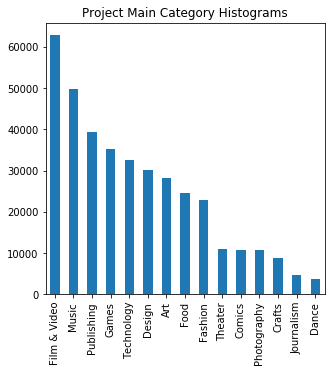

In [26]:
kickproj.groupby(['main_category']).size().reset_index(name='counts')
kickproj['main_category'].value_counts().plot(kind='bar', title='Project Main Category Histograms')

,country,counts
0,AT,597
1,AU,7839
2,BE,617
3,CA,14756
4,CH,761
5,DE,4171
6,DK,1113
7,ES,2276
8,FR,2939
9,GB,33672


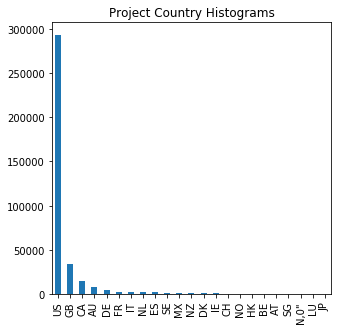

In [27]:
kickproj.groupby(['country']).size().reset_index(name='counts')
kickproj['country'].value_counts().plot(kind='bar', title='Project Country Histograms')

### Check null value 

In [38]:
null_columns=kickproj.columns[kickproj.isnull().any()]
null_columns
kickproj[null_columns].isnull().sum()
print(kickproj[kickproj["name"].isnull()][null_columns])

Index([u'name'], dtype='object')

name    4
dtype: int64

       name
166851  NaN
307234  NaN
309991  NaN
338931  NaN


#### Apply correct data types to DataFrame:

In [28]:
print 'Data types do not align with the data types defined in the data dictionary:\n\n', kickproj.dtypes

Data types do not align with the data types defined in the data dictionary:

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
launched             object
state                object
backers               int64
country              object
usd_pledged_real    float64
usd_goal_real       float64
dtype: object


In [39]:
# Columns that are of date data type:
datecols = ['deadline','launched']
# Columns that are of int data type:
intcols = ['usd_pledged_real','usd_goal_real']

for col in datecols:
    kickproj[col] = pd.to_datetime(kickproj[col])

# Convert date columns to date data type:
#kickproj[datecols] = kickproj[datecols].applymap(pd.to_datetime).applymap(lambda x: x.date()).applymap(pd.to_datetime)
# Convert int columns to int data type:
kickproj[intcols] = kickproj[intcols].fillna(0).astype(np.int64)

In [40]:
print 'Review converted data types:\n\n', kickproj.dtypes

Review converted data types:

ID                           int64
name                        object
category                    object
main_category               object
currency                    object
deadline            datetime64[ns]
launched            datetime64[ns]
state                       object
backers                      int64
country                     object
usd_pledged_real             int64
usd_goal_real                int64
dtype: object


#### Create Projects Summary DataFrame:

In [ ]:
kickproj_summary = kickproj.groupby(['main_category','state'], as_index=False) \
[['usd_goal_real','usd_pledged_real','backers']].agg({
    'usd_goal_real':[np.sum, np.mean, np.std],
    'usd_pledged_real':[np.sum, np.mean, np.std],
    'backers':[np.sum, np.mean, np.std,'count']
})

#"Flatten" summary results:
kickproj_summary.columns = list(map('_'.join, kickproj_summary.columns.values))

#Rename a few columns:
kickproj_summary.columns.values[-1] = 'project_count'
kickproj_summary.columns.values[0] = 'main_category'
kickproj_summary.columns.values[1] = 'state'

kickproj_summary.head()

#### Data Visualization

In [ ]:
from ggplot import *

In [ ]:
ggplot(kickproj, aes(x='backers', y='usd_pledged_real', color='state')) +\
    geom_point(size=1) +\
    xlab('backers') + ylab('usd_pledged_real') + ggtitle('Backers v. Pledged\nFaceted by Project State') +\
    scale_x_continuous(limits=(0,max(kickproj.backers))) +\
    scale_y_continuous(limits=(0,max(kickproj.usd_pledged_real))) +\
    theme_bw() +\
    facet_wrap('state')    

In [ ]:
fig=plt.figure(figsize=(16, 16), dpi= 100, facecolor='w', edgecolor='k')

ggplot(kickproj[(kickproj['state'] =='successful')], aes(x='backers', y='usd_pledged_real', color='state')) +\
    geom_point(size=1) +\
    xlab('backers') + ylab('usd_pledged_real') + ggtitle('Backers v. Pledged\nState is equal to Successful') +\
    scale_x_continuous(limits=(0,150000),labels='comma') +\
    scale_y_continuous(limits=(0,max(kickproj.usd_pledged_real)),labels='comma') +\
    theme_bw() 